In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable, Any
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time

In [2]:
from scipy import stats as sp
from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict, List


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [3]:
data = pd.read_pickle(os.path.join(PATH_INTERMEDIATE, 'proc_loc.pkl'))

In [4]:
# Check the type of the loaded data
print(f"Type of data: {type(data)}")

Type of data: <class 'dict'>


In [5]:
# List all keys in the dictionary
print("Keys in the data dictionary:")
print(data.keys())

Keys in the data dictionary:
dict_keys(['LOC_LABEL'])


In [6]:
data

{'LOC_LABEL': pcode  timestamp                       
 P126   2021-12-06 15:30:30.622000+09:00      none
        2021-12-06 15:32:16.025000+09:00      none
        2021-12-06 15:34:15.170000+09:00      none
        2021-12-06 15:39:25.419000+09:00      none
        2021-12-06 15:41:02.878000+09:00    social
                                             ...  
 P083   2021-12-28 23:33:06.771000+09:00      home
        2021-12-28 23:39:04.200000+09:00      home
        2021-12-28 23:45:01.310000+09:00      home
        2021-12-28 23:45:36.581000+09:00      home
        2021-12-28 23:51:40.129000+09:00      home
 Name: label, Length: 612941, dtype: object}

In [7]:
data

{'LOC_LABEL': pcode  timestamp                       
 P126   2021-12-06 15:30:30.622000+09:00      none
        2021-12-06 15:32:16.025000+09:00      none
        2021-12-06 15:34:15.170000+09:00      none
        2021-12-06 15:39:25.419000+09:00      none
        2021-12-06 15:41:02.878000+09:00    social
                                             ...  
 P083   2021-12-28 23:33:06.771000+09:00      home
        2021-12-28 23:39:04.200000+09:00      home
        2021-12-28 23:45:01.310000+09:00      home
        2021-12-28 23:45:36.581000+09:00      home
        2021-12-28 23:51:40.129000+09:00      home
 Name: label, Length: 612941, dtype: object}

In [8]:
# Define the list of relevant keys for Mobility
relevant_keys_mobility = ['LOC_LABEL']

In [9]:
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Function to remove duplicates by keeping the first occurrence
def remove_duplicates(series, key):
    initial_count = len(series)
    series_unique = series[~series.index.duplicated(keep='first')]
    duplicates_removed = initial_count - len(series_unique)
    if duplicates_removed > 0:
        logger.info(f"Removed {duplicates_removed} duplicate entries in {key}.")
    else:
        logger.info(f"No duplicates found in {key}.")
    return series_unique

# Process 'LOC_LABEL' data
def process_mobility_data(data: Dict[str, any]) -> pd.DataFrame:
    """
    Processes the 'LOC_LABEL' data and returns a cleaned DataFrame.

    Parameters:
    - data (Dict[str, any]): The raw data dictionary.

    Returns:
    - pd.DataFrame: Cleaned LOC_LABEL DataFrame.
    """
    key = 'LOC_LABEL'
    if key not in data:
        logger.error(f"Key '{key}' not found in data.")
        return pd.DataFrame()

    value = data[key]
    logger.info(f"Processing key: {key}, Type: {type(value)}")

    if not isinstance(value, pd.Series):
        logger.error(f"Expected pd.Series for '{key}', got {type(value)}. Skipping.")
        return pd.DataFrame()

    # Remove duplicates by keeping the first occurrence
    value_unique = remove_duplicates(value, key)

    # Convert Series to DataFrame
    df = value_unique.to_frame(name=key)

    # Handle missing values
    df[key].fillna('unknown', inplace=True)

    # Ensure MultiIndex ['pcode', 'timestamp']
    if not isinstance(df.index, pd.MultiIndex):
        df.reset_index(inplace=True)
        df.set_index(['pcode', 'timestamp'], inplace=True)
        logger.info("Set MultiIndex to ['pcode', 'timestamp'].")
    else:
        logger.info("DataFrame already has a MultiIndex.")

    # Convert 'timestamp' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df.index.get_level_values('timestamp')):
        df.index = df.index.set_levels(
            [
                df.index.get_level_values('pcode'),
                pd.to_datetime(df.index.get_level_values('timestamp'))
            ]
        )
        logger.info("Converted 'timestamp' to datetime.")

    # Remove duplicate indices
    df = df[~df.index.duplicated(keep='first')]
    logger.info("Removed duplicate index entries.")

    return df

# Process the mobility data
mobility_df = process_mobility_data(data)

# Display the first few rows
if not mobility_df.empty:
    print("\nProcessed Mobility DataFrame Head:")
    print(mobility_df.head())
else:
    logger.error("Mobility DataFrame is empty after processing.")

2024-11-12 19:45:17,631 - INFO - Processing key: LOC_LABEL, Type: <class 'pandas.core.series.Series'>
2024-11-12 19:45:17,656 - INFO - Removed 36 duplicate entries in LOC_LABEL.
2024-11-12 19:45:17,665 - INFO - DataFrame already has a MultiIndex.
2024-11-12 19:45:17,711 - INFO - Removed duplicate index entries.



Processed Mobility DataFrame Head:
                                       LOC_LABEL
pcode timestamp                                 
P126  2021-12-06 15:30:30.622000+09:00      none
      2021-12-06 15:32:16.025000+09:00      none
      2021-12-06 15:34:15.170000+09:00      none
      2021-12-06 15:39:25.419000+09:00      none
      2021-12-06 15:41:02.878000+09:00    social


In [26]:
mobility_df.LOC_LABEL.value_counts()

home      303520
none      107203
work       83467
eating     65519
social     33148
others     16396
gym         3652
Name: LOC_LABEL, dtype: int64

In [11]:
from typing import Dict
from scipy import stats as sp

def extract_mobility_features(window_data: pd.Series) -> Dict[str, float]:
    """
    Extracts mobility-related features from a window of LOC_LABEL data.

    Parameters:
    - window_data (pd.Series): Series of location labels within the window.

    Returns:
    - Dict[str, float]: Dictionary of extracted mobility features.
    """
    features = {}
    try:
        if window_data.empty:
            logger.debug("Window data is empty.")
            return features

        # Number of location changes
        loc_changes = window_data.ne(window_data.shift()).sum() - 1  # subtract 1 for the first entry
        loc_changes = max(loc_changes, 0)  # Ensure non-negative
        features['LOC_CHANGE_CNT'] = loc_changes

        # Entropy of location labels
        counts = window_data.value_counts()
        entropy = sp.entropy(counts, base=2)
        features['LOC_ENTROPY'] = entropy

        # Time spent in each location
        # Calculate time differences
        timestamps = window_data.index.get_level_values('timestamp')
        time_deltas = timestamps.to_series().diff().dt.total_seconds().fillna(0)

        # Assign time deltas to current location
        # The time delta represents the time spent since the last timestamp to current
        # For the first entry, time delta is 0
        loc_time = window_data.shift().fillna(method='bfill').groupby(window_data).apply(
            lambda x: time_deltas[x.index].sum()
        )

        # Populate time spent in each location
        for loc, dur in loc_time.items():
            features[f'LOC_TIME_{loc.upper()}'] = dur / 60  # Convert seconds to minutes

        # Most frequent location
        if not counts.empty:
            mode_loc = counts.idxmax()
            features['LOC_MODE'] = mode_loc
        else:
            features['LOC_MODE'] = 'unknown'

        # Average duration between location changes
        if loc_changes > 0:
            avg_dur = time_deltas.sum() / loc_changes
            features['LOC_AVG_DUR'] = avg_dur / 60  # minutes
            features['LOC_STD_DUR'] = time_deltas.std() / 60  # minutes
        else:
            features['LOC_AVG_DUR'] = 0
            features['LOC_STD_DUR'] = 0

    except Exception as e:
        logger.error(f"Error extracting mobility features: {e}")

    return features

In [12]:
def sliding_window_feature_extraction_mobility(
    mobility_df: pd.DataFrame,
    window_size_minutes: int,
    step_size_minutes: int = None
) -> pd.DataFrame:
    """
    Extracts mobility features using a sliding window approach.

    Parameters:
    - mobility_df (pd.DataFrame): DataFrame with 'LOC_LABEL' and MultiIndex ['pcode', 'timestamp'].
    - window_size_minutes (int): Size of the sliding window in minutes.
    - step_size_minutes (int, optional): Step size in minutes. Defaults to window_size_minutes.

    Returns:
    - pd.DataFrame: Extracted mobility features.
    """
    if step_size_minutes is None:
        step_size_minutes = window_size_minutes  # Default to non-overlapping windows

    extracted_features = []

    # Ensure the DataFrame is sorted by pcode and timestamp
    mobility_df = mobility_df.sort_index(level=['pcode', 'timestamp'])

    for pcode, group in mobility_df.groupby(level='pcode'):
        # Process each user (pcode) separately

        # Reset 'pcode' level from index and keep 'timestamp' as a column
        group = group.reset_index(level='pcode', drop=True).reset_index()

        # Set 'timestamp' as datetime index for easy slicing using time ranges
        group = group.set_index('timestamp')

        # Define the start and end of the entire timeframe for the current pcode
        start_time = group.index.min()
        end_time = group.index.max()

        # Initialize the current window start and end times
        current_start = start_time
        current_end = current_start + pd.Timedelta(minutes=window_size_minutes)

        # Slide the window until the end time
        while current_end <= end_time:
            # Extract data within the current sliding window
            window = group[current_start:current_end]

            # Initialize a dictionary to store features for this window
            feature_row = {}
            feature_row['pcode'] = pcode
            feature_row['window_end_time'] = current_end

            # Extract location label data for the window
            data = window['LOC_LABEL']

            # Extract mobility features using the `extract_mobility_features()` function
            mobility_feats = extract_mobility_features(data)
            if not mobility_feats:
                pass  # If no features are extracted, do nothing
            else:
                feature_row.update(mobility_feats)  # Add extracted features to the feature row

            # Only add the feature row if it contains at least one feature
            if feature_row:
                extracted_features.append(feature_row)

            # Move the window forward by step_size_minutes
            current_start += pd.Timedelta(minutes=step_size_minutes)
            current_end = current_start + pd.Timedelta(minutes=window_size_minutes)

    # Convert extracted features list to DataFrame
    mobility_feature_df = pd.DataFrame(extracted_features)

    # If the DataFrame is not empty, set the index to ['pcode', 'window_end_time']
    if not mobility_feature_df.empty:
        mobility_feature_df = mobility_feature_df.set_index(['pcode', 'window_end_time'])

    return mobility_feature_df

In [21]:
# Define window parameters
window_size = 60  # minutes
step_size = 60    # minutes (non-overlapping)

# Extract mobility features using sliding window
features_df_mobility = sliding_window_feature_extraction_mobility(
    mobility_df=mobility_df[['LOC_LABEL']],
    window_size_minutes=window_size,
    step_size_minutes=step_size
)

# Display the first few rows
print("\nExtracted Mobility Features DataFrame Head:")
print(features_df_mobility.head())


Extracted Mobility Features DataFrame Head:
                                        LOC_CHANGE_CNT  LOC_ENTROPY  \
pcode window_end_time                                                 
P001  2021-11-24 02:23:14.159000+09:00             0.0          0.0   
      2021-11-24 03:23:14.159000+09:00             0.0          0.0   
      2021-11-24 04:23:14.159000+09:00             0.0          0.0   
      2021-11-24 05:23:14.159000+09:00             0.0          0.0   
      2021-11-24 06:23:14.159000+09:00             0.0          0.0   

                                        LOC_TIME_HOME LOC_MODE  LOC_AVG_DUR  \
pcode window_end_time                                                         
P001  2021-11-24 02:23:14.159000+09:00      57.584217     home          0.0   
      2021-11-24 03:23:14.159000+09:00      55.754583     home          0.0   
      2021-11-24 04:23:14.159000+09:00      58.302083     home          0.0   
      2021-11-24 05:23:14.159000+09:00      54.069183     home

In [24]:
len(features_df_mobility) - len(features_df_mobility.dropna(how='all'))

16297

In [15]:
# Replace NaN values in LOC_TIME_* columns with 0
loc_time_columns = [col for col in features_df_mobility.columns if col.startswith('LOC_TIME_')]
features_df_mobility[loc_time_columns] = features_df_mobility[loc_time_columns].fillna(0)

# If there are any other columns with NaN values that should be zero, include them as well
features_df_mobility = features_df_mobility.fillna({'LOC_CHANGE_CNT': 0, 'LOC_ENTROPY': 0, 'LOC_AVG_DUR': 0, 'LOC_STD_DUR': 0})

In [16]:
# Check for any remaining NaN values
nan_counts = features_df_mobility.isna().sum()
print("Missing Values per Feature After Filling NaNs:\n", nan_counts)

Missing Values per Feature After Filling NaNs:
 LOC_CHANGE_CNT         0
LOC_ENTROPY            0
LOC_TIME_HOME          0
LOC_MODE           16297
LOC_AVG_DUR            0
LOC_STD_DUR            0
LOC_TIME_NONE          0
LOC_TIME_WORK          0
LOC_TIME_EATING        0
LOC_TIME_SOCIAL        0
LOC_TIME_OTHERS        0
LOC_TIME_GYM           0
dtype: int64


In [17]:
# Reset index to access 'pcode' as a column
features_df_reset = features_df_mobility.reset_index()

# List of location time columns
loc_time_columns = [col for col in features_df_mobility.columns if col.startswith('LOC_TIME_')]

# Aggregate total time spent at each location per user
total_time_per_location = features_df_reset.groupby('pcode')[loc_time_columns].sum()

print("Total Time Spent at Each Location per User (in minutes):\n")
print(total_time_per_location)

Total Time Spent at Each Location per User (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P001    18866.458133    1408.282250    5147.267483      1105.856117   
P002    14298.098217    1153.750233    1244.944000      2308.787683   
P003    15856.664500    1286.415133    1657.033450      3260.984417   
P007    13260.797833    1656.489267    5574.334517      3229.153783   
P008    16235.346883    2553.219883    7260.901650      5891.212200   
...              ...            ...            ...              ...   
P126     4199.718333    3034.960217    4867.965350      1286.426183   
P127     5614.493500    3096.553783    4106.515983      2533.156800   
P131     8743.219267    3734.992117    4729.976333      1630.712133   
P133    14005.039517    2182.601600    3310.951650      4556.442950   
P135     6456.228650    1790.235833     511.338983      2281.144383   

       LOC_TIME_SO

In [18]:
# Calculate average time spent at each location per user per window
avg_time_per_location = features_df_reset.groupby('pcode')[loc_time_columns].mean()

print("Average Time Spent at Each Location per User per Window (in minutes):\n")
print(avg_time_per_location)

Average Time Spent at Each Location per User per Window (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P001       28.456196       2.124106       7.763601         1.667958   
P002       21.245317       1.714339       1.849842         3.430591   
P003       23.596227       1.914308       2.465824         4.852655   
P007       19.645626       2.454058       8.258273         4.783932   
P008       15.301929       2.406428       6.843451         5.552509   
...              ...            ...            ...              ...   
P126        5.865528       4.238771       6.798834         1.796685   
P127        7.526131       4.150876       5.504713         3.395653   
P131       10.383871       4.435858       5.617549         1.936713   
P133       19.950199       3.109119       4.716455         6.490659   
P135        9.196907       2.550193       0.728403         3.249493   

     

In [19]:
# Function to calculate proportion of time spent at each location
def calculate_time_proportions(df):
    df['TOTAL_TIME'] = df[loc_time_columns].sum(axis=1)
    for col in loc_time_columns:
        proportion_col = col.replace('LOC_TIME_', 'PROP_TIME_')
        df[proportion_col] = df[col] / df['TOTAL_TIME']
    return df

# Apply the function
features_df_with_proportions = calculate_time_proportions(features_df_reset)

# Display the DataFrame with proportions
print("DataFrame with Time Proportions:\n")
print(features_df_with_proportions.head())

DataFrame with Time Proportions:

  pcode                  window_end_time  LOC_CHANGE_CNT  LOC_ENTROPY  \
0  P001 2021-11-24 02:23:14.159000+09:00             0.0          0.0   
1  P001 2021-11-24 03:23:14.159000+09:00             0.0          0.0   
2  P001 2021-11-24 04:23:14.159000+09:00             0.0          0.0   
3  P001 2021-11-24 05:23:14.159000+09:00             0.0          0.0   
4  P001 2021-11-24 06:23:14.159000+09:00             0.0          0.0   

   LOC_TIME_HOME LOC_MODE  LOC_AVG_DUR  LOC_STD_DUR  LOC_TIME_NONE  \
0      57.584217     home          0.0          0.0            0.0   
1      55.754583     home          0.0          0.0            0.0   
2      58.302083     home          0.0          0.0            0.0   
3      54.069183     home          0.0          0.0            0.0   
4      58.552200     home          0.0          0.0            0.0   

   LOC_TIME_WORK  ...  LOC_TIME_OTHERS  LOC_TIME_GYM  TOTAL_TIME  \
0            0.0  ...              0.0

In [20]:
# Replace NaN proportions with zero where TOTAL_TIME is zero
prop_time_columns = [col for col in features_df_with_proportions.columns if col.startswith('PROP_TIME_')]
features_df_with_proportions[prop_time_columns] = features_df_with_proportions[prop_time_columns].fillna(0)

In [20]:
# Define the list of selected users
selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

In [21]:
# Ensure 'features_df_mobility' has a MultiIndex
if not isinstance(features_df_mobility.index, pd.MultiIndex):
    features_df_mobility.reset_index(inplace=True)
    features_df_mobility.set_index(['pcode', 'window_end_time'], inplace=True)

# Filter the DataFrame for selected users
filtered_df = features_df_mobility.loc[selected_users]

# Display the first few rows of the filtered DataFrame
print("\nFiltered Mobility Features DataFrame Head:")
print(filtered_df.head())


Filtered Mobility Features DataFrame Head:
                                        LOC_CHANGE_CNT  LOC_ENTROPY  \
pcode window_end_time                                                 
P102  2021-12-02 23:40:20.768000+09:00             0.0     0.000000   
      2021-12-03 00:40:20.768000+09:00             0.0     0.000000   
      2021-12-03 01:40:20.768000+09:00             2.0     0.721928   
      2021-12-03 02:40:20.768000+09:00             0.0     0.000000   
      2021-12-03 03:40:20.768000+09:00             0.0     0.000000   

                                        LOC_TIME_HOME LOC_MODE  LOC_AVG_DUR  \
pcode window_end_time                                                         
P102  2021-12-02 23:40:20.768000+09:00      59.923533     home     0.000000   
      2021-12-03 00:40:20.768000+09:00      44.704083     home     0.000000   
      2021-12-03 01:40:20.768000+09:00      18.851167     home    11.343858   
      2021-12-03 02:40:20.768000+09:00       0.000000     home 

In [22]:
# Identify columns that represent time spent at locations
loc_time_columns = [col for col in filtered_df.columns if col.startswith('LOC_TIME_')]
print("\nLOC_TIME Columns:")
print(loc_time_columns)


LOC_TIME Columns:
['LOC_TIME_HOME', 'LOC_TIME_NONE', 'LOC_TIME_WORK', 'LOC_TIME_EATING', 'LOC_TIME_SOCIAL', 'LOC_TIME_OTHERS', 'LOC_TIME_GYM']


In [23]:
# Reset index to access 'pcode' as a column
filtered_reset_df = filtered_df.reset_index()

# Calculate total time spent at each location per user
total_time_per_location = filtered_reset_df.groupby('pcode')[loc_time_columns].sum()

print("\nTotal Time Spent at Each Location per User (in minutes):\n")
print(total_time_per_location)


Total Time Spent at Each Location per User (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P007    13260.797833    1656.489267    5574.334517      3229.153783   
P020    10520.813133    1954.546217      15.941567      1389.224683   
P045     5733.440217    2492.662200    3636.026400      1707.932033   
P102    11667.777167    2921.894167    2184.710517      1113.280233   
P120     3882.753800    3292.323417    1903.302583      5456.459550   

       LOC_TIME_SOCIAL  LOC_TIME_OTHERS  LOC_TIME_GYM  
pcode                                                  
P007        530.071617       622.618000      0.000000  
P020        777.650083        27.178967     48.795833  
P045       2151.596367         9.136500    419.868467  
P102        346.779867       385.045283    911.085017  
P120       1563.914183       336.809333   1013.966217  


In [24]:
# Calculate average time spent at each location per user
avg_time_per_location = filtered_reset_df.groupby('pcode')[loc_time_columns].mean()

print("\nAverage Time Spent at Each Location per User per Window (in minutes):\n")
print(avg_time_per_location)


Average Time Spent at Each Location per User per Window (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P007       19.645626       2.454058       8.258273         4.783932   
P020       15.291880       2.840910       0.023171         2.019222   
P045        8.544620       3.714847       5.418817         2.545353   
P102       16.479911       4.126969       3.085749         1.572430   
P120        5.282658       4.479352       2.589527         7.423754   

       LOC_TIME_SOCIAL  LOC_TIME_OTHERS  LOC_TIME_GYM  
pcode                                                  
P007          0.785291         0.922397      0.000000  
P020          1.130305         0.039504      0.070924  
P045          3.206552         0.013616      0.625735  
P102          0.489802         0.543849      1.286843  
P120          2.127774         0.458244      1.379546  


In [25]:
# Calculate total time per user
total_time = total_time_per_location.sum(axis=1)

# Calculate proportion of time spent at each location
proportion_time = total_time_per_location.div(total_time, axis=0)

# Rename columns for clarity
proportion_time.columns = [col.replace('LOC_TIME_', 'PROP_TIME_') for col in proportion_time.columns]

print("\nProportion of Time Spent at Each Location per User:\n")
print(proportion_time)


Proportion of Time Spent at Each Location per User:

       PROP_TIME_HOME  PROP_TIME_NONE  PROP_TIME_WORK  PROP_TIME_EATING  \
pcode                                                                     
P007         0.533130        0.066597        0.224108          0.129823   
P020         0.714043        0.132654        0.001082          0.094286   
P045         0.354997        0.154338        0.225132          0.105750   
P102         0.597411        0.149606        0.111861          0.057002   
P120         0.222513        0.188677        0.109075          0.312700   

       PROP_TIME_SOCIAL  PROP_TIME_OTHERS  PROP_TIME_GYM  
pcode                                                     
P007           0.021311          0.025031       0.000000  
P020           0.052779          0.001845       0.003312  
P045           0.133220          0.000566       0.025997  
P102           0.017756          0.019715       0.046649  
P120           0.089625          0.019302       0.058109  


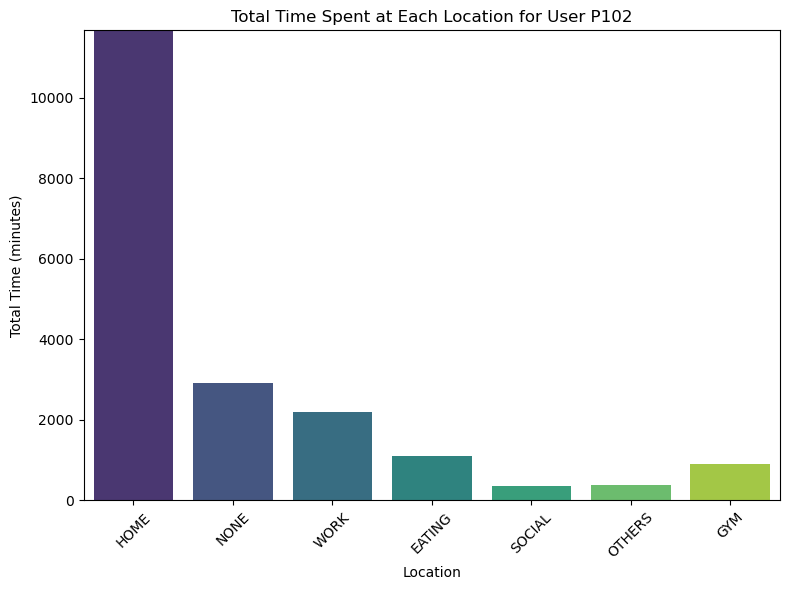

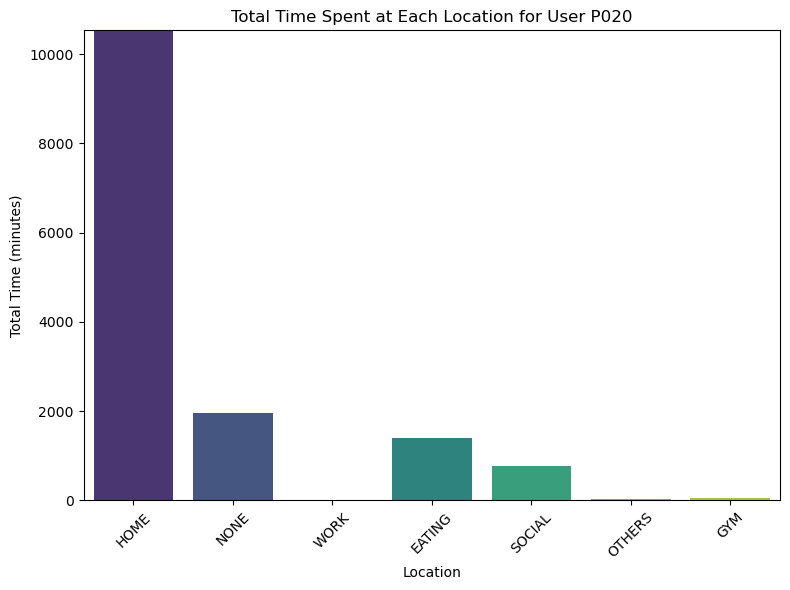

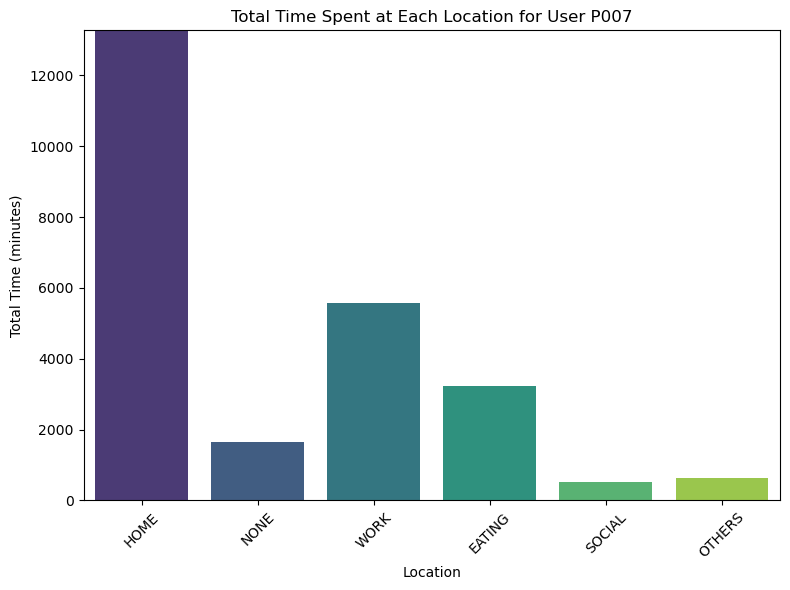

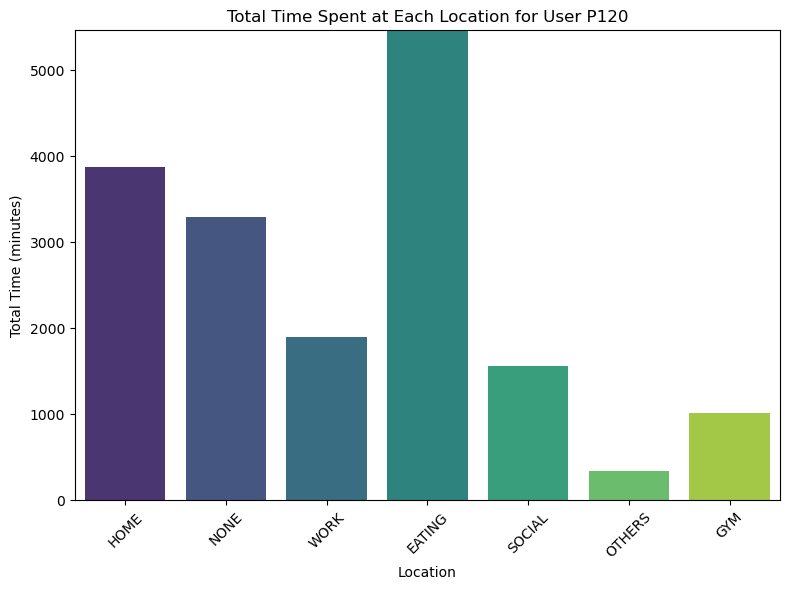

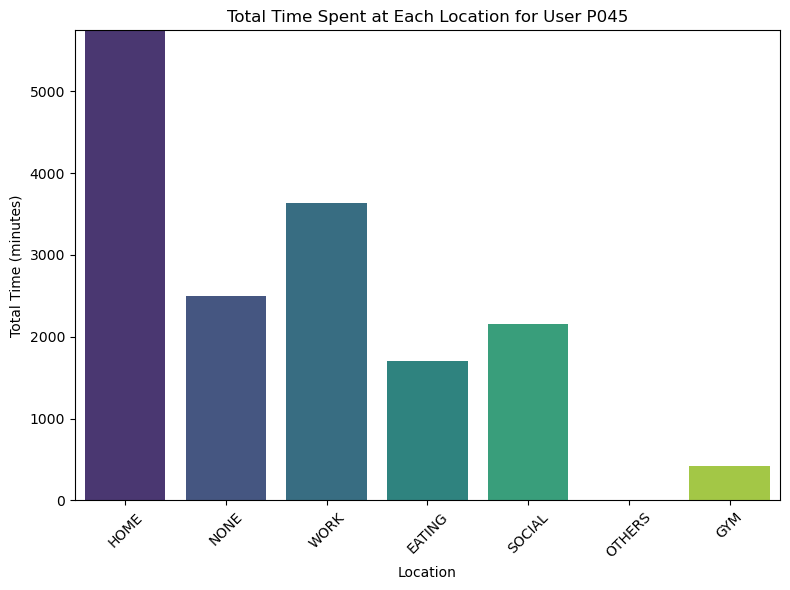

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over each selected user to create individual bar charts
for pcode in selected_users:
    user_data = total_time_per_location.loc[pcode]
    user_data = user_data[user_data > 0]  # Filter out locations with zero time
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=user_data.index.str.replace('LOC_TIME_', ''), y=user_data.values, palette='viridis')
    plt.title(f'Total Time Spent at Each Location for User {pcode}')
    plt.xlabel('Location')
    plt.ylabel('Total Time (minutes)')
    plt.xticks(rotation=45)
    plt.ylim(0, user_data.max() + 10)  # Adjust y-axis for better visualization
    plt.tight_layout()
    plt.show()

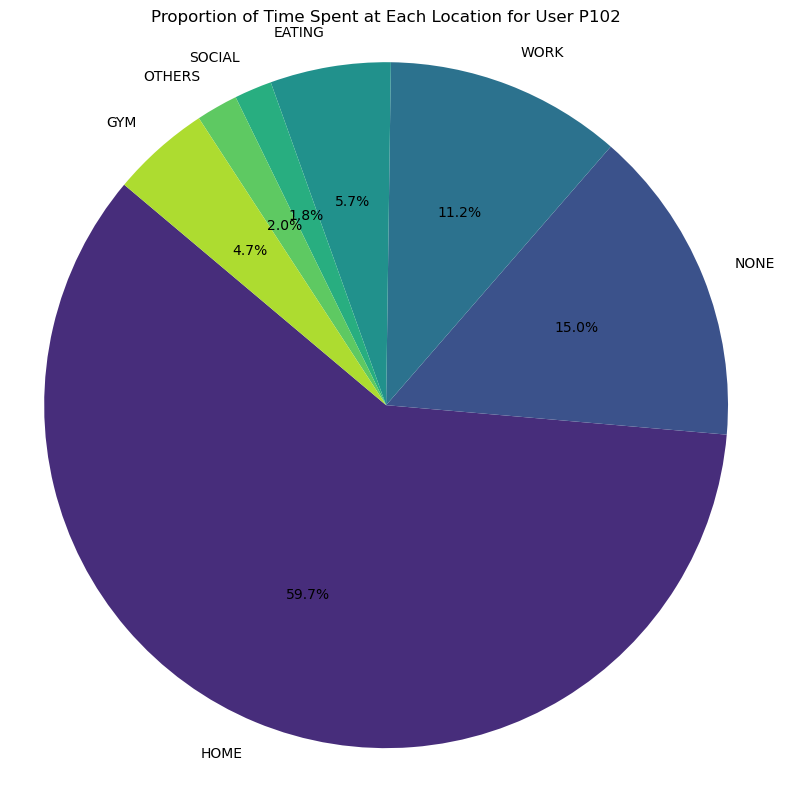

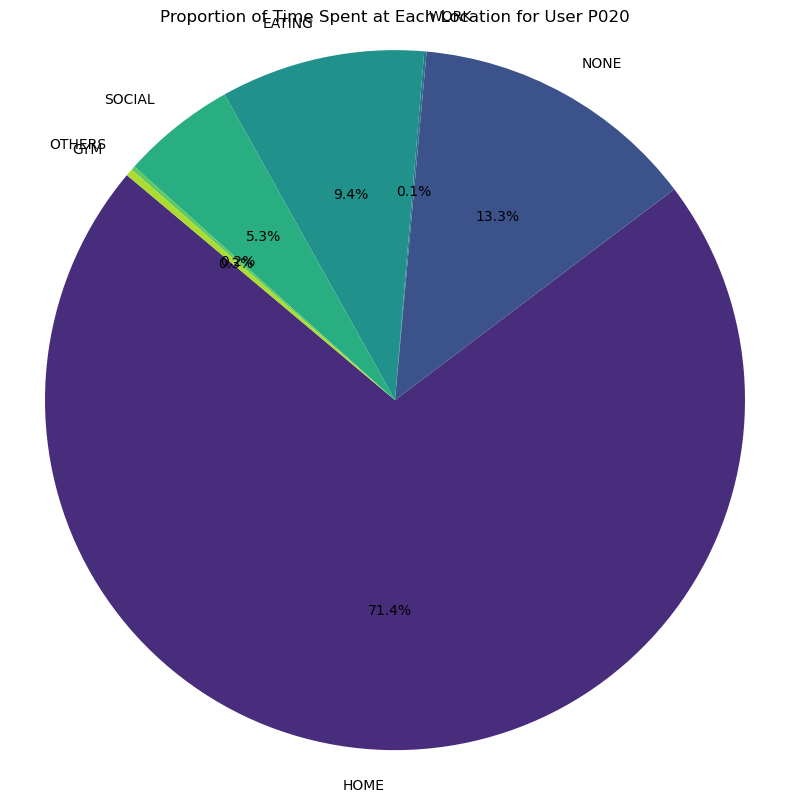

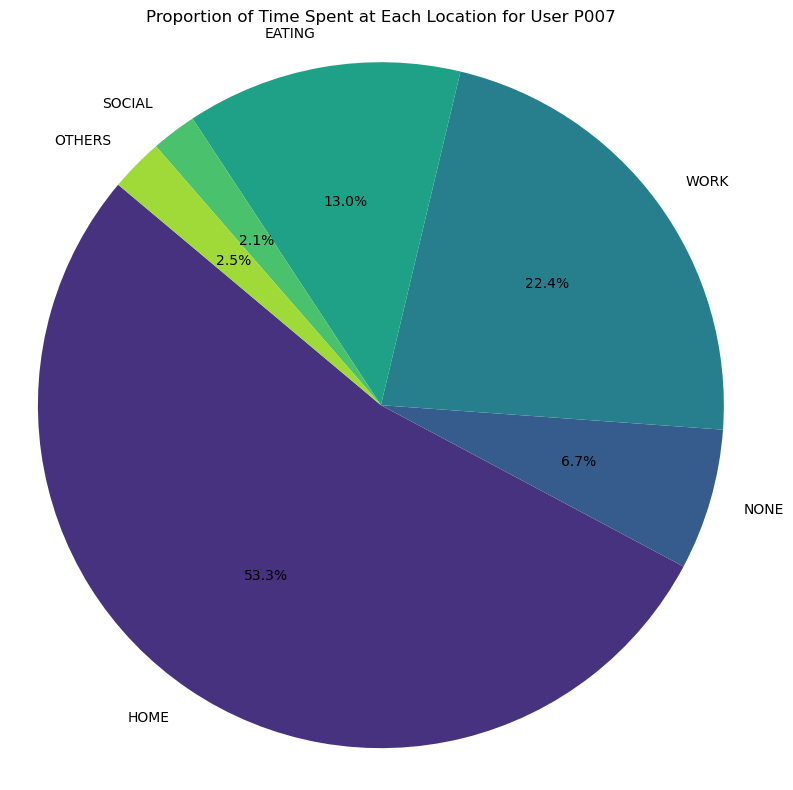

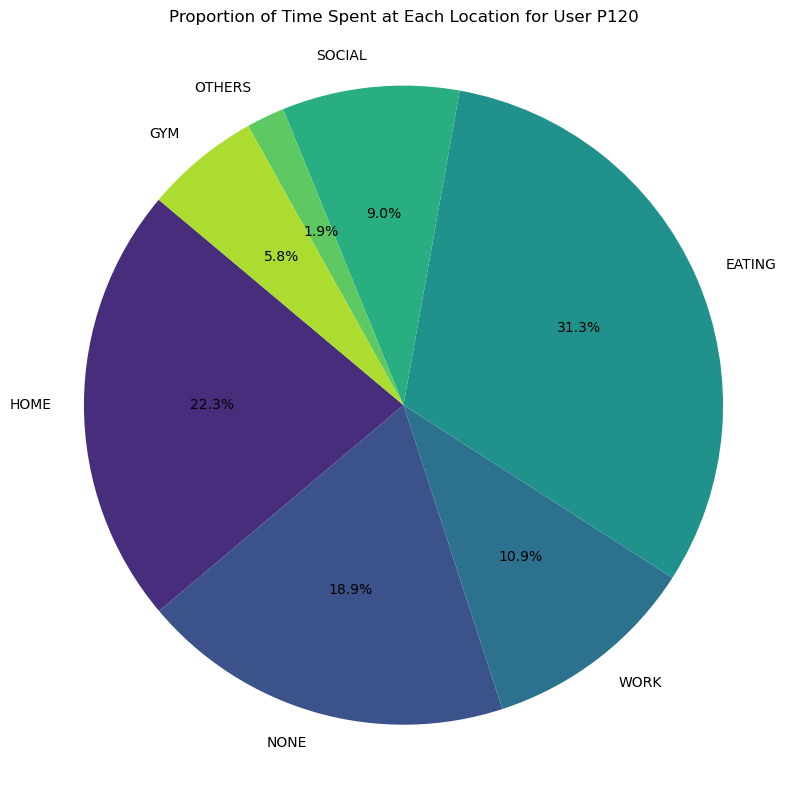

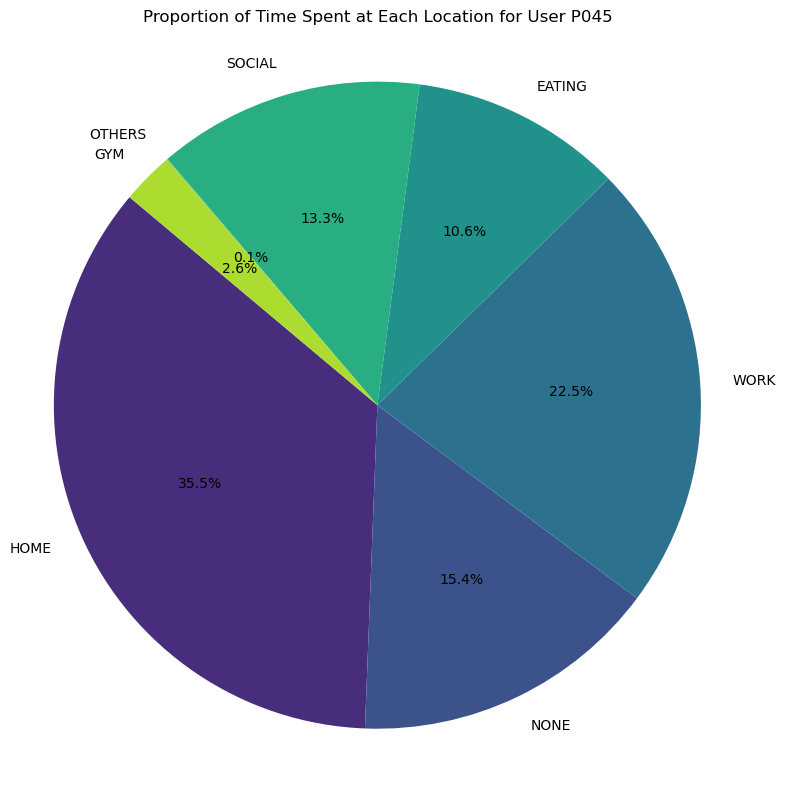

In [27]:
# Iterate over each selected user to create individual pie charts
for pcode in selected_users:
    user_proportion = proportion_time.loc[pcode]
    user_proportion = user_proportion[user_proportion > 0]  # Exclude zero proportions
    
    # If there are no non-zero proportions, skip plotting
    if user_proportion.empty:
        print(f"No time spent at any location for user {pcode}. Skipping pie chart.")
        continue
    
    plt.figure(figsize=(8, 8))
    plt.pie(user_proportion.values, labels=user_proportion.index.str.replace('PROP_TIME_', ''), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(user_proportion)))
    plt.title(f'Proportion of Time Spent at Each Location for User {pcode}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

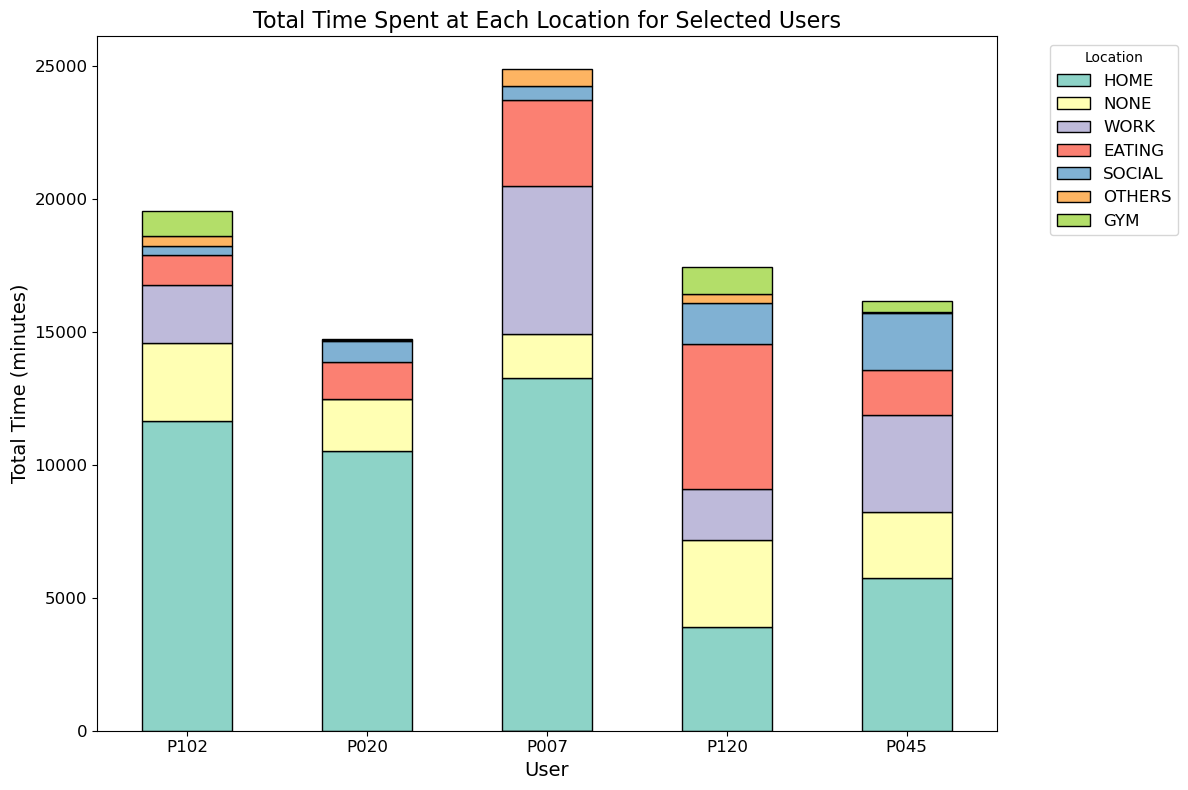

In [28]:
# # Alternatively, use the 'Set2' palette for distinct colors
# color_palette = sns.color_palette('Set2', n_colors=len(plot_data.columns))

# # Define a more contrasting color palette using 'tab20'
# color_palette = sns.color_palette('tab20', n_colors=len(plot_data.columns))

# # Define a custom list of contrasting colors
# color_palette = [
#     '#e41a1c',  # Red
#     '#377eb8',  # Blue
#     '#4daf4a',  # Green
#     '#984ea3',  # Purple
#     '#ff7f00',  # Orange
#     '#ffff33',  # Yellow
#     '#a65628',  # Brown
#     '#f781bf',  # Pink
#     '#999999',  # Grey
#     '#66c2a5'   # Teal
# ][:len(plot_data.columns)]  

import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant data for the selected users
plot_data = total_time_per_location.loc[selected_users]

# Rename columns by removing 'LOC_TIME_' prefix for clarity
plot_data = plot_data.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# Replace any remaining NaN values with 0 (if not already handled)
plot_data = plot_data.fillna(0)

# # Define a custom list of contrasting colors
color_palette = sns.color_palette('Set3', n_colors=len(plot_data.columns))
# Alternatively, you can choose another palette like 'Set2' or define custom colors as shown above

# Create a stacked bar chart
plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# Customize the plot
plt.title('Total Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Total Time (minutes)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()

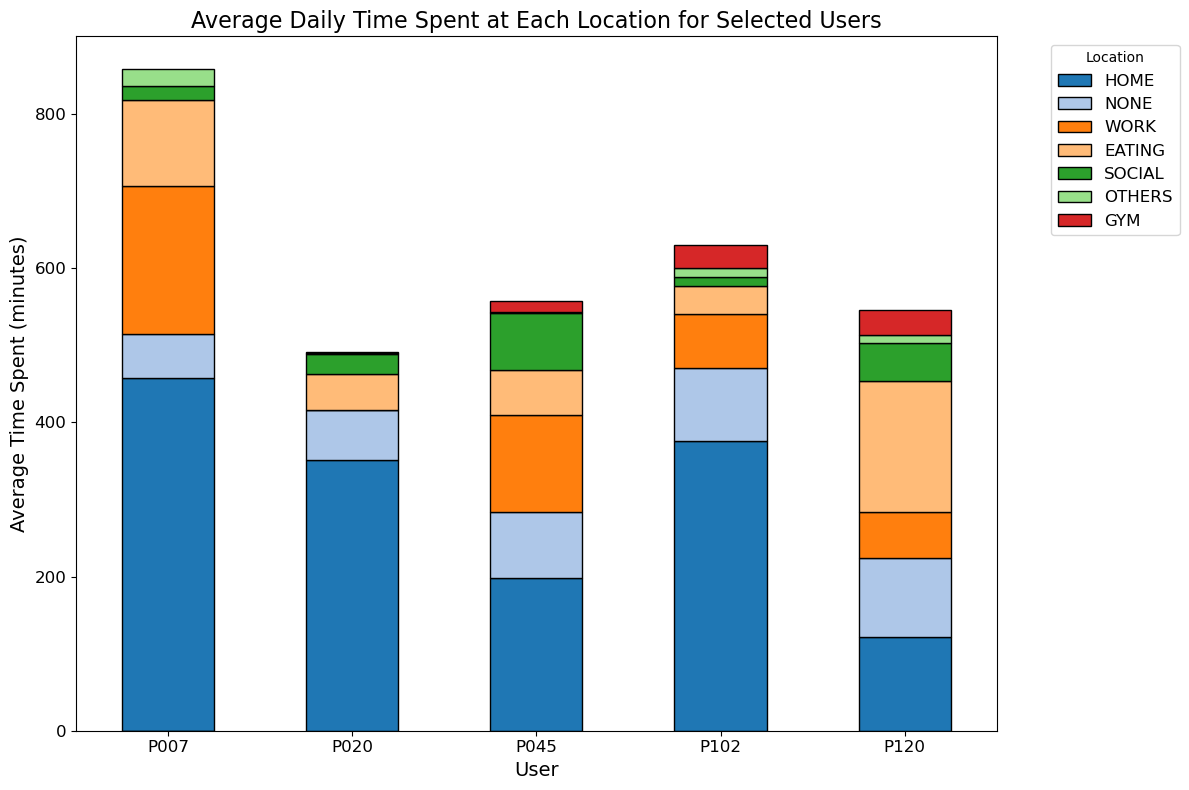

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'filtered_reset_df' is already defined and contains the cleaned data for selected users
# selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# 1. Extract the date from 'window_end_time'
filtered_reset_df['date'] = filtered_reset_df['window_end_time'].dt.date

# 2. Aggregate time spent at each location per user per day
daily_time = filtered_reset_df.groupby(['pcode', 'date'])[loc_time_columns].sum().reset_index()

# 3. Calculate the mean daily time spent at each location per user
mean_daily_time = daily_time.groupby('pcode')[loc_time_columns].mean()

# 4. Rename columns by removing 'LOC_TIME_' prefix for clarity
mean_daily_time = mean_daily_time.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# 5. Define a contrasting color palette using 'tab20' for better distinction
color_palette = sns.color_palette('tab20', n_colors=len(mean_daily_time.columns))

# 6. Create a stacked bar chart for mean daily time spent at each location
mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 7. Customize the plot
plt.title('Average Daily Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Average Time Spent (minutes)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()

# 8. Display the plot
plt.show()


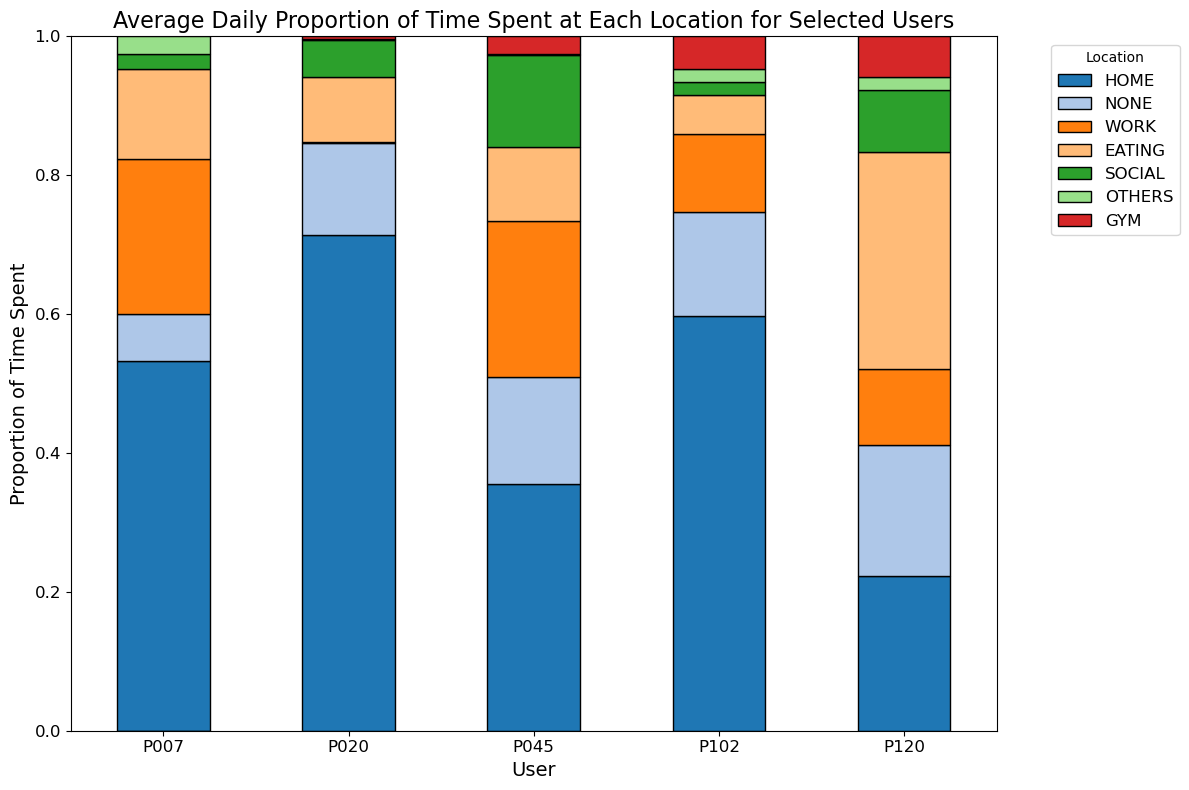

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mean_daily_time' is already defined and contains the mean daily time per location per user
# selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# 1. Normalize the data so that each user's total time sums to 1 (or 100%)
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0)

# 2. Replace any NaN values resulting from division by zero with 0
normalized_mean_daily_time = normalized_mean_daily_time.fillna(0)

# 3. Rename columns by removing 'LOC_TIME_' prefix for clarity
normalized_mean_daily_time = normalized_mean_daily_time.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# 4. Define a contrasting and colorblind-friendly color palette
# Using 'tab20' which has 20 distinct colors
color_palette = sns.color_palette('tab20', n_colors=len(normalized_mean_daily_time.columns))

# Alternatively, define a custom color palette for better distinction
# color_palette = [
#     '#e41a1c',  # Red
#     '#377eb8',  # Blue
#     '#4daf4a',  # Green
#     '#984ea3',  # Purple
#     '#ff7f00',  # Orange
#     '#ffff33',  # Yellow
#     '#a65628',  # Brown
#     '#f781bf',  # Pink
#     '#999999',  # Grey
#     '#66c2a5'   # Teal
# ][:len(normalized_mean_daily_time.columns)]  # Ensure the list matches the number of locations

# 5. Create a stacked bar chart with normalized data
ax = normalized_mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 6. Customize the plot
plt.title('Average Daily Proportion of Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Proportion of Time Spent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for proportions

# 8. Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 9. Adjust layout to make room for the legend
plt.tight_layout()

# 10. Display the plot
plt.show()


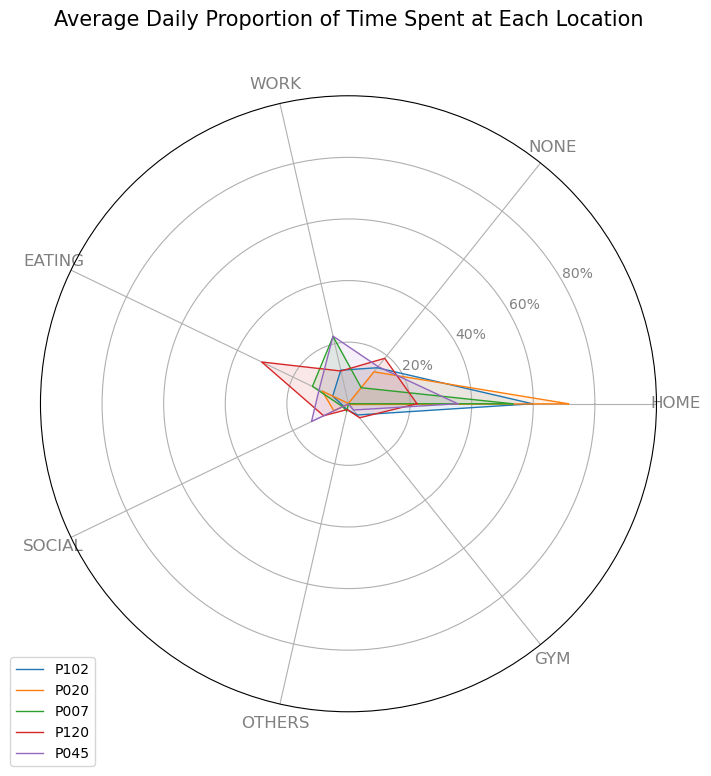

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'mean_daily_time' includes 'Traveling_Time'
# Normalize the data if not already normalized
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0).fillna(0)

# Select the data for radar charts
data = normalized_mean_daily_time.loc[selected_users]

# Number of variables
categories = list(data.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2,0.4,0.6,0.8], ["20%","40%","60%","80%"], color="grey", size=10)
plt.ylim(0,1)

# Plot each user
for user in selected_users:
    values = data.loc[user].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=user)
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Average Daily Proportion of Time Spent at Each Location', size=15, y=1.1)
plt.show()


In [32]:
# Calculate Traveling Time for each window
filtered_reset_df['LOC_TIME_TRAVEL'] = window_size - filtered_reset_df[loc_time_columns].sum(axis=1)

# Ensure that Traveling Time is not negative
filtered_reset_df['LOC_TIME_TRAVEL'] = filtered_reset_df['LOC_TIME_TRAVEL'].clip(lower=0)

# Optionally, rename the column for consistency
filtered_reset_df.rename(columns={'LOC_TIME_TRAVEL': 'Traveling_Time'}, inplace=True)

# Display the first few rows to verify
print("\nDataFrame with Calculated Traveling Time:\n", filtered_reset_df[['pcode', 'window_end_time', 'Traveling_Time']].head())


DataFrame with Calculated Traveling Time:
   pcode                  window_end_time  Traveling_Time
0  P102 2021-12-02 23:40:20.768000+09:00        0.076467
1  P102 2021-12-03 00:40:20.768000+09:00       15.295917
2  P102 2021-12-03 01:40:20.768000+09:00       37.312283
3  P102 2021-12-03 02:40:20.768000+09:00       60.000000
4  P102 2021-12-03 03:40:20.768000+09:00       60.000000


In [33]:
# 1. Extract the date from 'window_end_time' if not already done
filtered_reset_df['date'] = filtered_reset_df['window_end_time'].dt.date

# 2. Aggregate time spent at each location and Traveling_Time per user per day
# Include 'Traveling_Time' in the aggregation
aggregation_columns = loc_time_columns + ['Traveling_Time']
daily_time = filtered_reset_df.groupby(['pcode', 'date'])[aggregation_columns].sum().reset_index()

# 3. Calculate the mean daily time spent at each location and Traveling_Time per user
mean_daily_time = daily_time.groupby('pcode')[aggregation_columns].mean()

# 4. Rename columns by removing 'LOC_TIME_' prefix for clarity
mean_daily_time = mean_daily_time.rename(columns=lambda x: x.replace('LOC_TIME_', '') if x.startswith('LOC_TIME_') else x)

# Display the aggregated mean daily time
print("\nMean Daily Time Spent at Each Location and Traveling Time per User:\n", mean_daily_time)



Mean Daily Time Spent at Each Location and Traveling Time per User:
              HOME        NONE        WORK      EATING     SOCIAL     OTHERS  \
pcode                                                                         
P007   457.268891   57.120320  192.218432  111.350130  18.278332  21.469586   
P020   350.693771   65.151541    0.531386   46.307489  25.921669   0.905966   
P045   197.704835   85.953869  125.380221   58.894208  74.192978   0.315052   
P102   376.379909   94.254651   70.474533   35.912266  11.186447  12.420816   
P120   121.336056  102.885107   59.478206  170.514361  48.872318  10.525292   

             GYM  Traveling_Time  
pcode                             
P007    0.000000      538.846034  
P020    1.626528      884.861651  
P045   14.478223      831.356476  
P102   29.389839      740.304121  
P120   31.686444      832.827216  


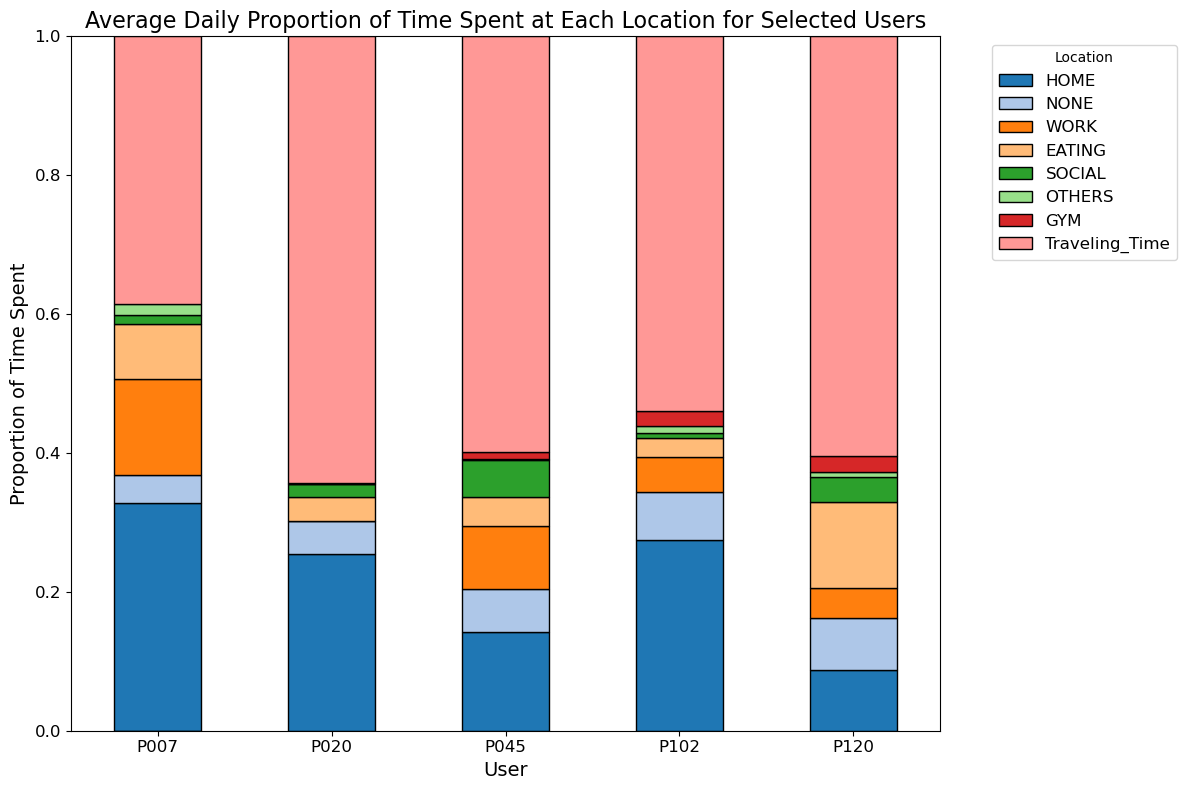

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Normalize the data so that each user's total time sums to 1 (or 100%)
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0)

# 2. Replace any NaN values resulting from division by zero with 0
normalized_mean_daily_time = normalized_mean_daily_time.fillna(0)

# 3. Rename columns by removing 'LOC_TIME_' prefix for clarity (if not already done)
# Already handled in previous step

# 4. Define a contrasting and colorblind-friendly color palette
# Using 'tab20' which has 20 distinct colors, more than enough for your locations
color_palette = sns.color_palette('tab20', n_colors=len(normalized_mean_daily_time.columns))

# 5. Create a stacked bar chart with normalized data
ax = normalized_mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 6. Customize the plot
plt.title('Average Daily Proportion of Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Proportion of Time Spent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for proportions

# 8. Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 9. Adjust layout to make room for the legend
plt.tight_layout()

# 10. Display the plot
plt.show()

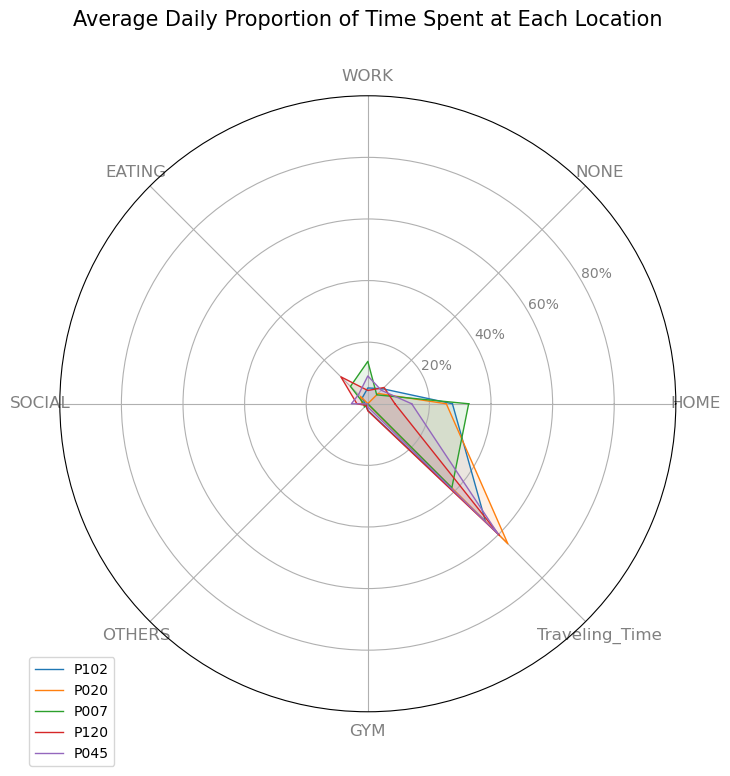

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'mean_daily_time' includes 'Traveling_Time'
# Normalize the data if not already normalized
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0).fillna(0)

# Select the data for radar charts
data = normalized_mean_daily_time.loc[selected_users]

# Number of variables
categories = list(data.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2,0.4,0.6,0.8], ["20%","40%","60%","80%"], color="grey", size=10)
plt.ylim(0,1)

# Plot each user
for user in selected_users:
    values = data.loc[user].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=user)
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Average Daily Proportion of Time Spent at Each Location', size=15, y=1.1)
plt.show()

2024-11-12 03:46:33,746 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-12 03:46:33,748 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


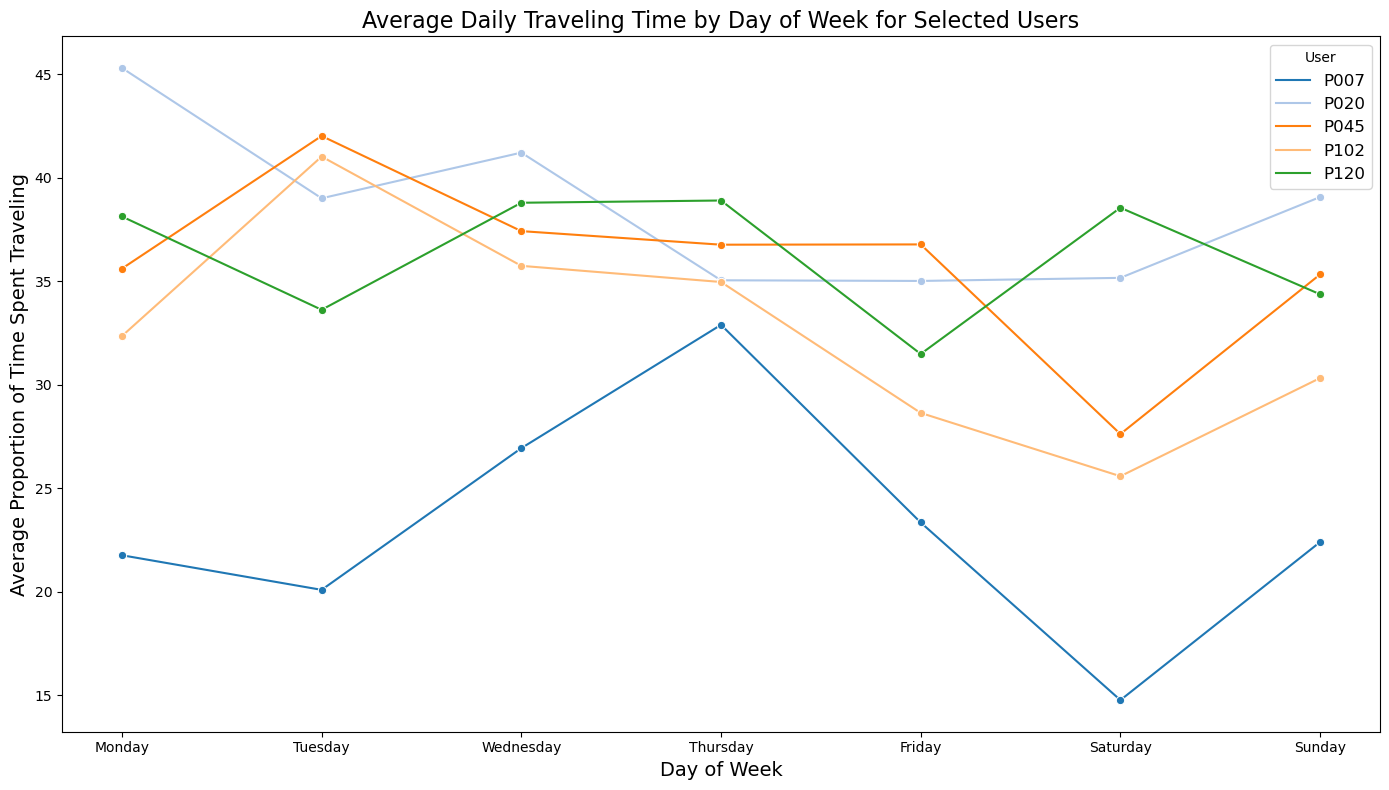

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'filtered_reset_df' includes 'date' and normalized 'Traveling_Time'

# Add 'day_of_week' for additional insights
filtered_reset_df['day_of_week'] = filtered_reset_df['window_end_time'].dt.day_name()

# Aggregate mean time per location per user per day of week
daily_time = filtered_reset_df.groupby(['pcode', 'day_of_week'])[loc_time_columns + ['Traveling_Time']].mean().reset_index()

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_time['day_of_week'] = pd.Categorical(daily_time['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=daily_time,
    x='day_of_week',
    y='Traveling_Time',
    hue='pcode',
    marker='o',
    palette='tab20'
)
plt.title('Average Daily Traveling Time by Day of Week for Selected Users', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Proportion of Time Spent Traveling', fontsize=14)
plt.legend(title='User', fontsize=12)
plt.tight_layout()
plt.show()


Selected Date for Visualization: 2021-12-11


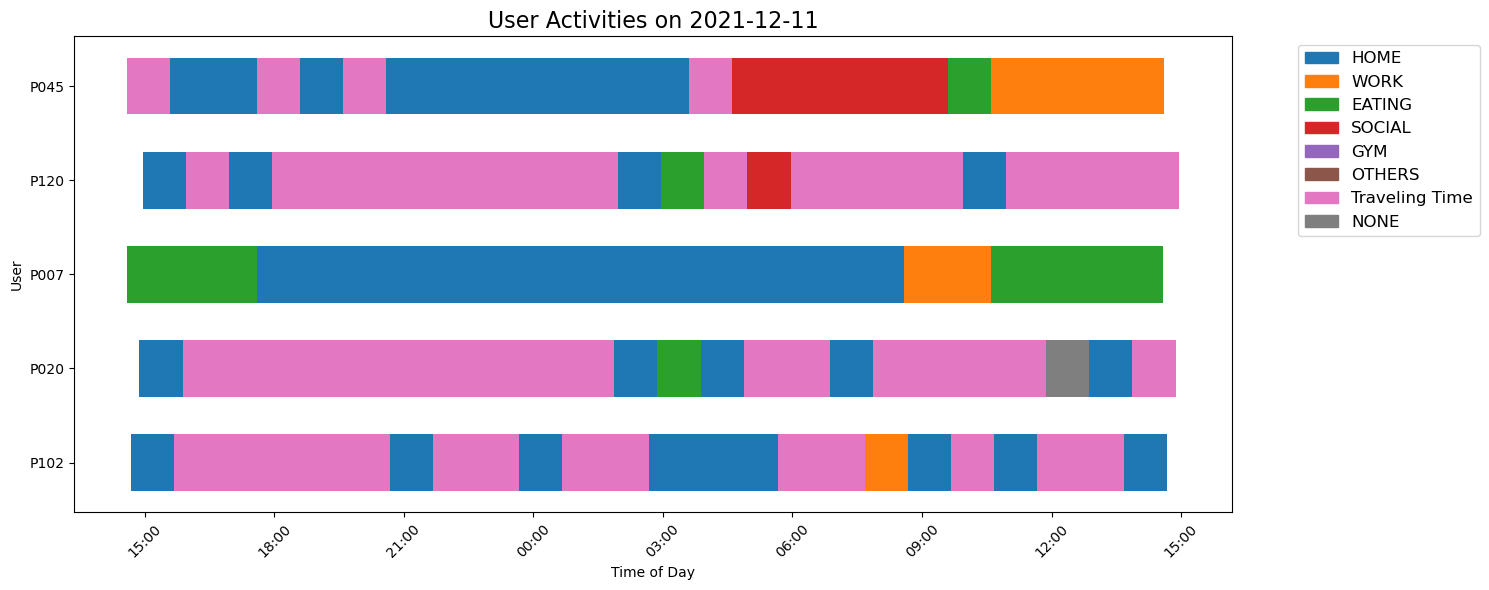

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.dates as mdates
import random

# Assuming 'filtered_reset_df' is your DataFrame with necessary columns

# Define the window size in minutes (adjust if different)
window_size = 60  # e.g., 60 minutes

# Select a random date present in the data
available_dates = filtered_reset_df['window_end_time'].dt.date.unique()
selected_date = random.choice(available_dates)
print(f"Selected Date for Visualization: {selected_date}")

# Filter data for the selected date and selected users
selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']
day_data = filtered_reset_df[
    (filtered_reset_df['pcode'].isin(selected_users)) &
    (filtered_reset_df['window_end_time'].dt.date == selected_date)
].copy()

# Check if all users have data for the selected date
users_with_data = day_data['pcode'].unique()
missing_users = set(selected_users) - set(users_with_data)
if missing_users:
    print(f"Warning: The following users do not have data for {selected_date}: {missing_users}")

# Assign primary activity per window based on maximum time spent
loc_time_columns = [col for col in day_data.columns if col.startswith('LOC_TIME_')]
day_data['Primary_Activity'] = day_data[loc_time_columns + ['Traveling_Time']].idxmax(axis=1)
day_data['Primary_Activity'] = day_data['Primary_Activity'].str.replace('LOC_TIME_', '').str.replace('_', ' ')

# Calculate start and end times for each activity
day_data['window_start_time'] = day_data['window_end_time'] - pd.to_timedelta(window_size, unit='m')
day_data = day_data.sort_values(['pcode', 'window_start_time'])

# Define a contrasting color palette
activity_colors = {
    'HOME': '#1f77b4',           # Blue
    'WORK': '#ff7f0e',           # Orange
    'EATING': '#2ca02c',         # Green
    'SOCIAL': '#d62728',         # Red
    'GYM': '#9467bd',            # Purple
    'OTHERS': '#8c564b',         # Brown
    'Traveling Time': '#e377c2'  # Pink
}

# Ensure all activities have a color
unique_activities = day_data['Primary_Activity'].unique()
for activity in unique_activities:
    if activity not in activity_colors:
        activity_colors[activity] = '#7f7f7f'  # Grey as default

# Convert 'window_start_time' to matplotlib date numbers
day_data['start_num'] = mdates.date2num(day_data['window_start_time'])
# Calculate duration in days (since matplotlib date units are in days)
day_data['duration_num'] = window_size / (24 * 60)  # e.g., 60 minutes

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Assign a y-position for each user
user_positions = {user: idx for idx, user in enumerate(selected_users)}
yticks = []
yticklabels = []
for user, pos in user_positions.items():
    yticks.append(pos)
    yticklabels.append(user)

# Set y-axis
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xlabel('Time of Day')
ax.set_ylabel('User')
ax.set_title(f'User Activities on {selected_date}', fontsize=16)

# Format x-axis as time
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Plot each activity as a horizontal bar
bar_height = 0.6  # Adjust as needed for better spacing
for _, row in day_data.iterrows():
    user = row['pcode']
    pos = user_positions[user]
    start_num = row['start_num']
    duration_num = row['duration_num']
    activity = row['Primary_Activity']
    color = activity_colors.get(activity, '#7f7f7f')  # Default to grey if not found
    ax.broken_barh(
        [(start_num, duration_num)],
        (pos - bar_height / 2, bar_height),
        facecolors=color
    )

# Create custom legend
legend_patches = [patches.Patch(color=color, label=activity) for activity, color in activity_colors.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()
